In [206]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

plt.style.use('ggplot')

## Read data

In [207]:
# print pandas version
print(pd.__version__)

1.5.3


In [208]:
df = pd.read_csv('./data/data.csv')

In [209]:
# display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Label analysis

In [210]:
# display all unique values in the diagnosis column
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [211]:
# convert diagnosis column to bool (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'] == 'M'

False    357
True     212
Name: diagnosis, dtype: int64


<Axes: title={'center': 'Distribution of label'}, ylabel='Frequency'>

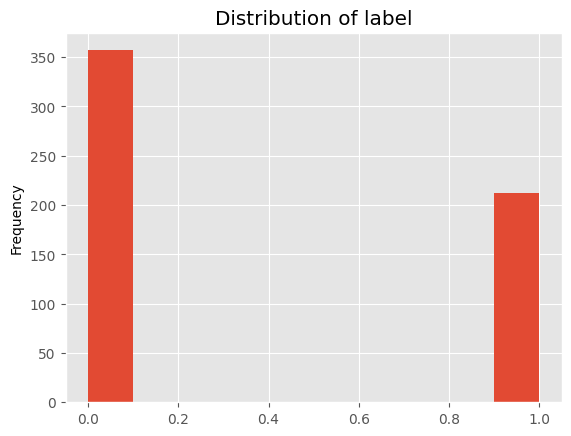

In [212]:
# check balance of diagnosis column
print(df['diagnosis'].value_counts())
# display histogram of diagnosis column
df['diagnosis'].astype('uint8').plot(kind='hist',
                                     title='Distribution of label')

## Feature selection

In [213]:
# Drop columns id and Unnamed: 32
df = df.drop(columns=['id', 'Unnamed: 32'])

In [214]:
# Analyse correlations of features with label
label_corr = pd.DataFrame(df.corr().diagnosis)

In [215]:
# Drop features barely correlating with label
important_features = label_corr.drop(label_corr[abs(label_corr.diagnosis) < 0.08].index)

<Axes: title={'center': 'Correlations with label'}>

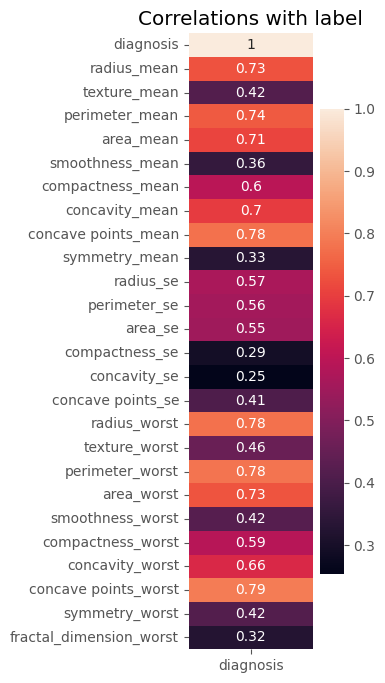

In [216]:
# Visualize the correlations
plt.subplots(figsize=(2,8))
plt.title('Correlations with label')
sns.heatmap(important_features, annot=True)

In [217]:
# Select only the important features
df = df[important_features.index]

<Axes: title={'center': 'Correlation matrix'}>

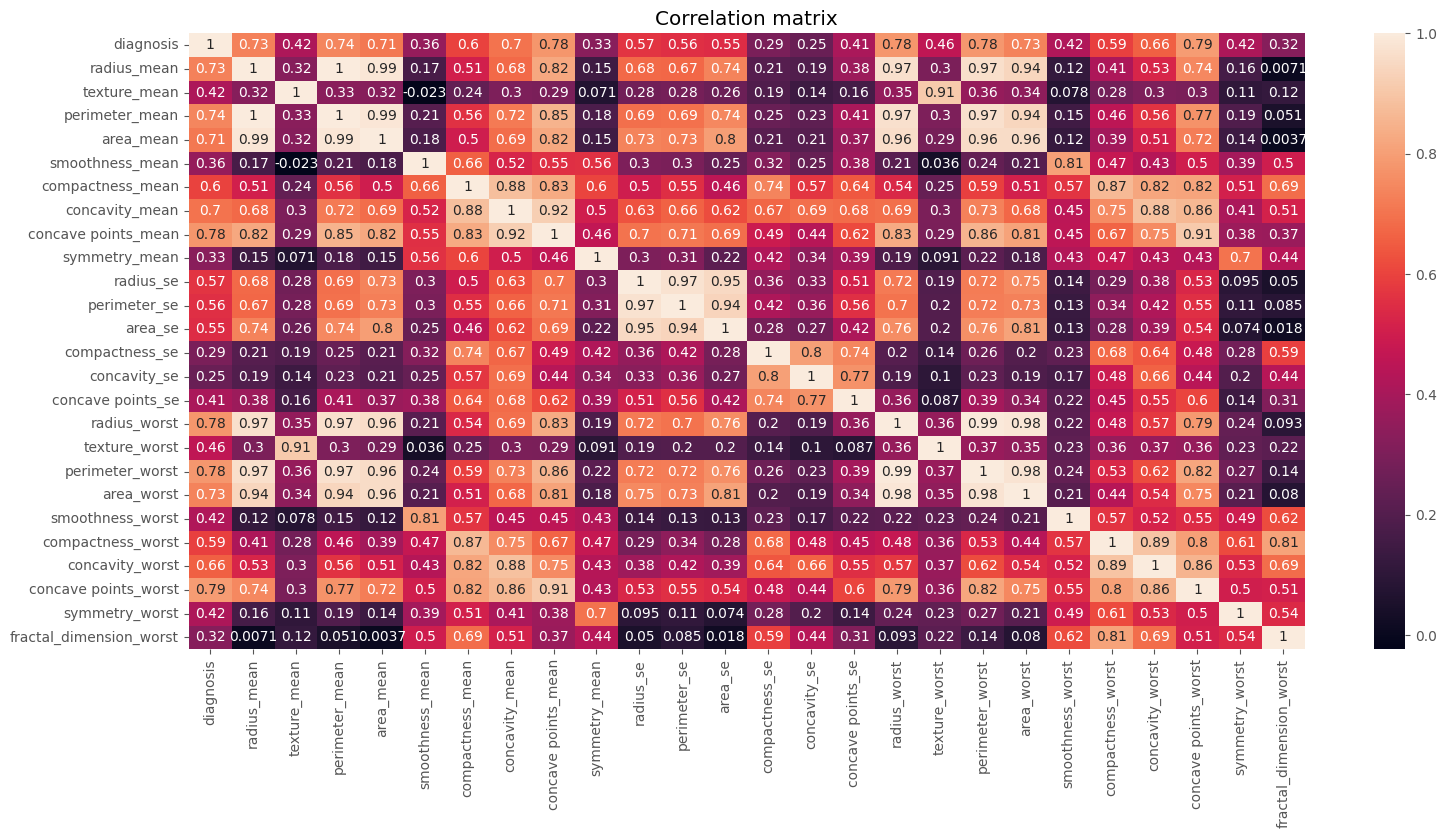

In [218]:
plt.subplots(figsize=(18,8))
plt.title('Correlation matrix')
sns.heatmap(df.corr(), annot=True, )

These features are all very correlated:
- radius_mean
- perimeter_mean
- area_mean
- radius_worst
- perimeter_worst
- area_worst

So we will preserve only 'radius_worst' since it has the highest correlation with label (along with 'perimeter_mean'), the others will be dropped

Same goes for:
- radius_se
- perimeter_se
- area_se

We preserve only 'radius_se' for same the reason as above.

In [219]:
# Drop correlated features
df = df.drop(columns= ['radius_mean', 'perimeter_mean', 'area_mean', 'perimeter_worst', 'area_worst', 'perimeter_se', 'area_se'])

## Features description and transformation
- No missing values
- All features continuous
- Target variable binary
- Target variable looks somewhat balanced, but maybe there is a room for under/oversampling, or smote

In [220]:
# Analyse distances between neighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(df.drop(columns=['diagnosis']))
distances, _ = nbrs.kneighbors(df.drop(columns=['diagnosis']))

In [221]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

Text(0, 0.5, 'Epsilon')

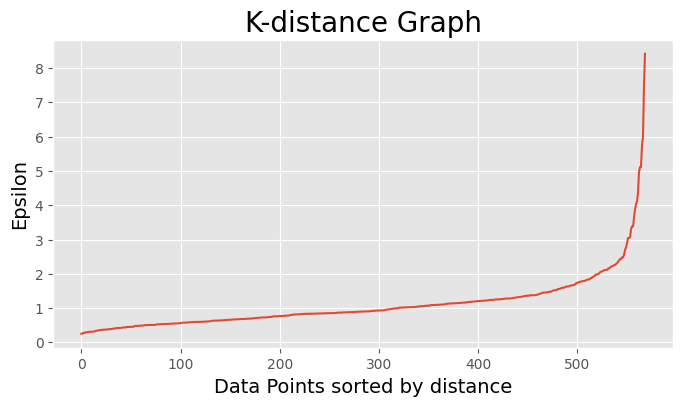

In [222]:
plt.subplots(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)

Epsilon is at the point of maximum curvature which I think is around 6. The other parametrs including min_samples will remain default.

In [223]:
# Check for outliers
dbscan = DBSCAN(eps=6)
dbscan.fit(df.drop(columns=['diagnosis']))

DBSCAN(eps=6)

In [224]:
# Check the result
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([  5, 564], dtype=int64))

There is **5** outliers

In [225]:
# Drop outliers
df = df[(dbscan.labels_ == 0).T]
df.shape

(564, 19)

In [226]:
# check variance of each column
df.var()

diagnosis                   0.232729
texture_mean               17.022584
smoothness_mean             0.000199
compactness_mean            0.002802
concavity_mean              0.006293
concave points_mean         0.001489
symmetry_mean               0.000754
radius_se                   0.065408
compactness_se              0.000323
concavity_se                0.000917
concave points_se           0.000038
radius_worst               22.525792
texture_worst              34.823945
smoothness_worst            0.000520
compactness_worst           0.024725
concavity_worst             0.043705
concave points_worst        0.004318
symmetry_worst              0.003826
fractal_dimension_worst     0.000325
dtype: float64

Some columns have high variance, there is a room for scaling.

In [227]:
# apply min-max normalization to all columns except diagnosis
df_norm = df.copy()
df_norm.drop(['diagnosis'], axis=1, inplace=True)
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())
# add diagnosis column to normalized dataframe
df_norm['diagnosis'] = df['diagnosis']

In [228]:
# check variance of each column after normalization
df_norm.var()

texture_mean               0.029308
smoothness_mean            0.016181
compactness_mean           0.026364
concavity_mean             0.034545
concave points_mean        0.036787
symmetry_mean              0.019225
radius_se                  0.011027
compactness_se             0.018238
concavity_se               0.005849
concave points_se          0.013771
radius_worst               0.028507
texture_worst              0.036781
smoothness_worst           0.022656
compactness_worst          0.023273
concavity_worst            0.027882
concave points_worst       0.050992
symmetry_worst             0.014868
fractal_dimension_worst    0.013989
diagnosis                  0.232729
dtype: float64

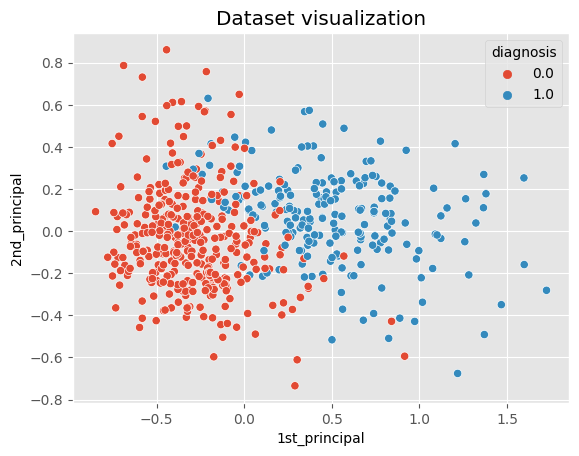

In [229]:
# visualize using PCA based on diagnosis column

# prepare PCA
pca = PCA(n_components=2)
# fit PCA to normalized dataframe
pca.fit(df_norm.drop(['diagnosis'], axis=1))

# transform normalized dataframe
pca_data = pca.transform(df_norm.drop(['diagnosis'], axis=1))
# add diagnosis column to transformed dataframe
pca_data = np.vstack((pca_data.T, df_norm['diagnosis'].astype('uint8'))).T

# create dataframe from transformed data
pca_df = pd.DataFrame(data=pca_data, columns=('1st_principal', '2nd_principal', 'diagnosis'))

# visualize transformed data
ax = sns.scatterplot(x='1st_principal',
                     y='2nd_principal',
                     hue='diagnosis',
                     data=pca_df)
ax.set_title('Dataset visualization')
plt.show()

Most of data can be separated even with a line in 2d space, it is expected, that future models will be able to classify data with high accuracy.